In [25]:
# Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
START_DATE = '2015-01-01'
TICKERS = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD']

In [26]:
# Download data for all tickers
data = yf.download(TICKERS, start=START_DATE, auto_adjust=True, progress=False)

# Calculate returns for each ticker
returns = data['Close'].pct_change()

# Calculate log returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))

# Add multi-level column names to returns DataFrames
returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])
log_returns.columns = pd.MultiIndex.from_product([['LogReturns'], log_returns.columns])

# Concatenate with original data
data = pd.concat([data, returns, log_returns], axis=1)

data = data.dropna()

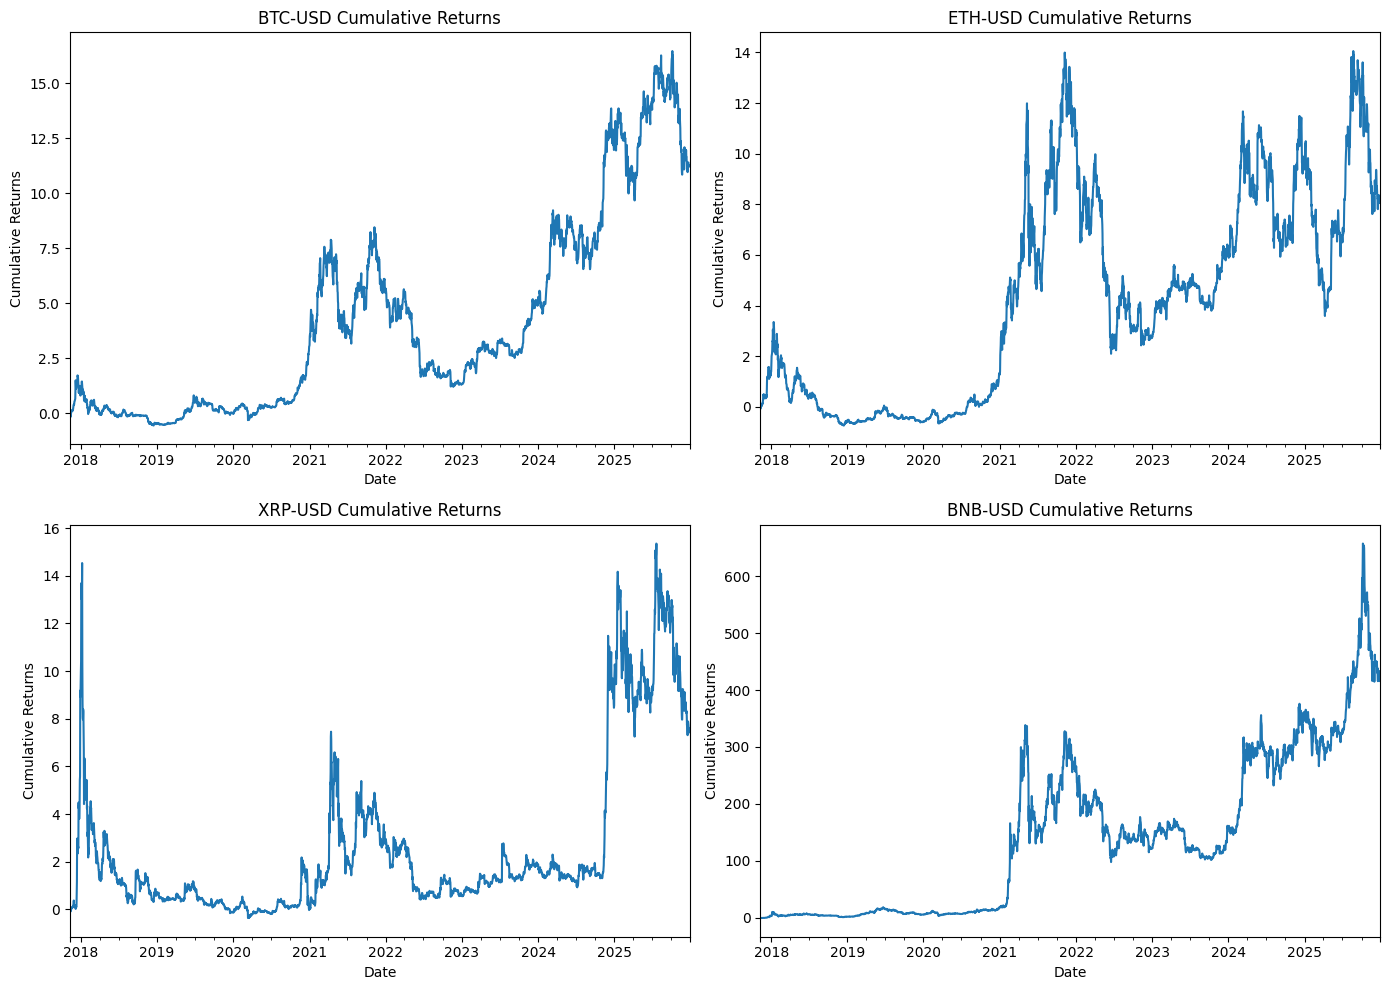


=== Summary Statistics ===
         Annualized Return  Annualized Volatility  Sharpe Ratio  Max Drawdown
BTC-USD           0.533642               0.669100      0.797552     -0.833990
ETH-USD           0.646160               0.860018      0.751334     -0.939625
XRP-USD           0.868847               1.144247      0.759318     -0.958661
BNB-USD           1.200086               0.973127      1.233227     -0.801024


In [ ]:
# Plot cumulative returns and display summary statistics - annualized returns and volatility, Sharpe ratio and drawdown

cumulative_returns = (1 + data['Returns']).cumprod() - 1

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, ticker in enumerate(TICKERS):
    cumulative_returns[ticker].plot(ax=axes[idx], title=f'{ticker} Cumulative Returns')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
trading_days = 365  # Crypto markets trade 365 days a year

summary_stats = pd.DataFrame(index=TICKERS)

for ticker in TICKERS:
    returns_series = data['Returns'][ticker]
    
    # Annualized returns
    annualized_return = returns_series.mean() * trading_days
    
    # Annualized volatility
    annualized_volatility = returns_series.std() * np.sqrt(trading_days)
    
    # Sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    
    # Maximum drawdown
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    summary_stats.loc[ticker, 'Annualized Return'] = annualized_return
    summary_stats.loc[ticker, 'Annualized Volatility'] = annualized_volatility
    summary_stats.loc[ticker, 'Sharpe Ratio'] = sharpe_ratio
    summary_stats.loc[ticker, 'Max Drawdown'] = max_drawdown

print(summary_stats.to_string())